# Weekly U.S. No 2 Diesel Retail Prices forecasting with Tensorflow-keras

Dataset can be found on [EIA's website](https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=emd_epd2d_pte_nus_dpg&f=w) 


<br>


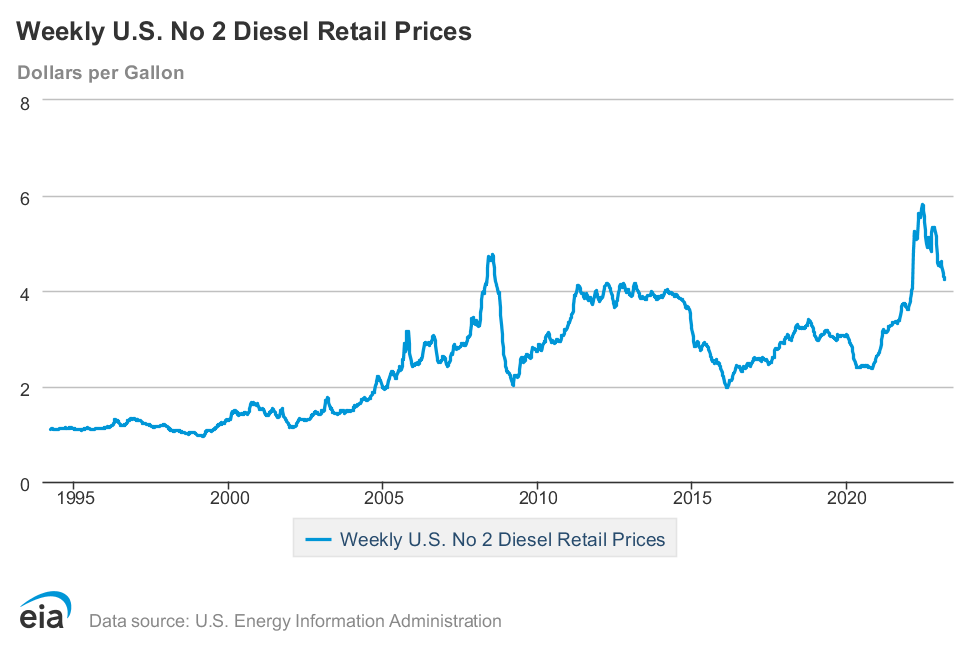

## Data Processing

In [ ]:
# import necessary packages 

import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from keras import layers

In [ ]:
# Read in CSV file
df = pd.read_csv('/content/Weekly_U.S._No_2_Diesel_Retail_Prices.csv', index_col='Week of', header=0)

# Convert "Week of" column to datetime format
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')



In [ ]:
df.head()

,Weekly U.S. No 2 Diesel Retail Prices Dollars per Gallon
Week of,
2023-03-13,4.247
2023-03-06,4.282
2023-02-27,4.294
2023-02-20,4.376
2023-02-13,4.444


In [ ]:
time_step = []
price_item = []

with open('/content/Weekly_U.S._No_2_Diesel_Retail_Prices.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    price_item.append(float(row[1]))
    time_step.append((row[0]))

print(len(time_step), len(price_item))

series = np.array(price_item)
time = np.array(time_step)

1513 1513


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

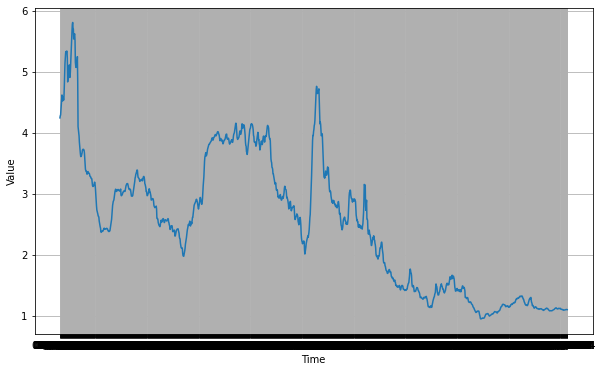

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time, series)

In [ ]:
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)


In [ ]:
    # Number of features in the dataset. We use all features as predictors to predict all features of future time steps.
    N_FEATURES = len(df.columns)

    # Normalizes the data
    data = df.values
    data = data
    data = normalize_series(data, data.min(axis=0) ,data.max(axis=0) )

    # Splits the data into training and validation sets.
    SPLIT_TIME = int(len(data) * 0.8)
    x_train = data[:SPLIT_TIME]
    x_valid = data[SPLIT_TIME:]

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)


    BATCH_SIZE = 32 


    # Number of past time steps based on which future observations should be predicted
    N_PAST = 10  # DO NOT CHANGE THIS

    # Number of future time steps which are to be predicted.
    N_FUTURE = 10 

    # By how many positions the window slides to create a new window of observations.
    SHIFT = 1  # DO NOT CHANGE THIS

    # Code to create windowed train and validation datasets.
    train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
    valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)


In [ ]:
# Get one batch of the dataset
for x_batch, y_batch in valid_set.take(1):
    # Print the shape of x_batch and y_batch
    print('x_batch shape:', x_batch.shape)
    print('y_batch shape:', y_batch.shape)


x_batch shape: (32, 10, 1)
y_batch shape: (32, 10, 1)


## Model Implementation 

In [ ]:
MAX_EPOCHS = 50
performance_dict = {}


In [ ]:

def compile_and_fit(model, patience=2):

  tf.keras.backend.clear_session()
  tf.random.set_seed(42)

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)


  ModelCheckpoint = [
      keras.callbacks.ModelCheckpoint(f"diesel_retail_{model.name}.keras",
      save_best_only=True)]

  optimizer = keras.optimizers.Adam()

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train_set, epochs=MAX_EPOCHS,
                      validation_data=valid_set,
                      callbacks=[early_stopping, ModelCheckpoint], verbose=2, batch_size = 32)
  
  performance_dict[f"{model.name}"] = last_val_loss = [ f"loss : {history.history['loss'][-1]}" , f"mae : {history.history['mean_absolute_error'][-1]}", f"val_loss : {history.history['val_loss'][-1]}" , f"val_mae : {history.history['val_mean_absolute_error'][-1]}" ]
  
  return history

In [ ]:
 #### simple densely connected network

inputs = keras.Input(shape=(10,1))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x) 

dense_model = keras.Model(inputs, outputs, name="dense_model")

In [ ]:
dense_model.summary()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 dense (Dense)               (None, 10, 64)            128       
                                                                 
 dense_1 (Dense)             (None, 10, 64)            4160      
                                                                 
 dense_2 (Dense)             (None, 10, 1)             65        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_and_fit(dense_model)

Epoch 1/50
38/38 - 2s - loss: 0.0866 - mean_absolute_error: 0.2377 - val_loss: 0.0096 - val_mean_absolute_error: 0.0974 - 2s/epoch - 43ms/step
Epoch 2/50
38/38 - 0s - loss: 0.0114 - mean_absolute_error: 0.0855 - val_loss: 0.0167 - val_mean_absolute_error: 0.1289 - 281ms/epoch - 7ms/step
Epoch 3/50
38/38 - 0s - loss: 0.0066 - mean_absolute_error: 0.0664 - val_loss: 0.0105 - val_mean_absolute_error: 0.1022 - 324ms/epoch - 9ms/step


In [ ]:
performance_dict['dense_model']

['loss : 0.00660212617367506',
 'mae : 0.06637141853570938',
 'val_loss : 0.010544492863118649',
 'val_mae : 0.10220623761415482']

In [ ]:
### lstm model

inputs = keras.Input(shape=(10,1))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)
outputs = layers.Dense(1)(x)

lstm_model = keras.Model(inputs, outputs, name="lstm_model")

In [ ]:
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            8320      
                                                                 
 dense (Dense)               (None, 10, 1)             33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_and_fit(lstm_model, patience=8)

Epoch 1/50
38/38 - 5s - loss: 0.0731 - mean_absolute_error: 0.2211 - val_loss: 0.0172 - val_mean_absolute_error: 0.1217 - 5s/epoch - 120ms/step
Epoch 2/50
38/38 - 0s - loss: 0.0324 - mean_absolute_error: 0.1399 - val_loss: 0.0153 - val_mean_absolute_error: 0.1192 - 379ms/epoch - 10ms/step
Epoch 3/50
38/38 - 0s - loss: 0.0249 - mean_absolute_error: 0.1194 - val_loss: 0.0098 - val_mean_absolute_error: 0.0959 - 394ms/epoch - 10ms/step
Epoch 4/50
38/38 - 0s - loss: 0.0194 - mean_absolute_error: 0.1014 - val_loss: 0.0070 - val_mean_absolute_error: 0.0723 - 387ms/epoch - 10ms/step
Epoch 5/50
38/38 - 0s - loss: 0.0160 - mean_absolute_error: 0.0904 - val_loss: 0.0075 - val_mean_absolute_error: 0.0743 - 357ms/epoch - 9ms/step
Epoch 6/50
38/38 - 0s - loss: 0.0140 - mean_absolute_error: 0.0844 - val_loss: 0.0079 - val_mean_absolute_error: 0.0755 - 366ms/epoch - 10ms/step
Epoch 7/50
38/38 - 0s - loss: 0.0126 - mean_absolute_error: 0.0803 - val_loss: 0.0080 - val_mean_absolute_error: 0.0747 - 397ms

In [ ]:
lstm_model = keras.models.load_model("diesel_retail_lstm_model.keras")


In [ ]:
performance_dict['lstm_model']

['loss : 0.0031367759220302105',
 'mae : 0.039540935307741165',
 'val_loss : 0.0008436240023002028',
 'val_mae : 0.017543824389576912']